# Heterogenous Agent Neoclassical Model - HANC

**Table of contents**<a id='toc0_'></a>    
- 1. [Setup](#toc1_)    
- 2. [Transition path](#toc2_)    
  - 2.1. [Step 1: steady state](#toc2_1_)    
  - 2.2. [Step 2: Jacobian](#toc2_2_)    
  - 2.3. [Step 3: Define shock](#toc2_3_)    
  - 2.4. [Step 4: Solve using Broyden's method](#toc2_4_)    
- 3. [HH jacobian + decomposition](#toc3_)    

<!-- vscode-jupyter-toc-config
	numbering=true
	anchor=true
	flat=false
	minLevel=2
	maxLevel=6
	/vscode-jupyter-toc-config -->
<!-- THIS CELL WILL BE REPLACED ON TOC UPDATE. DO NOT WRITE YOUR TEXT IN THIS CELL -->

**The steps of the sequence-space solution method are:**

1. Find the stationary equilibrium (steady state for aggregates and distribution).
2. Compute Jacobians of the household block and the full model (to unknowns and shocks)
3. Find the non-linear transition path or the linearized impulse responses to a given shock path.
4. Simulate the linearized model with aggregate risk

In [1]:
%load_ext autoreload
%autoreload 2

import time
import pickle
import numpy as np
from scipy import optimize

import matplotlib.pyplot as plt   
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
plt.rcParams.update({"axes.grid" : True, "grid.color": "black", "grid.alpha":"0.25", "grid.linestyle": "--"})
plt.rcParams.update({'font.size': 14})

from HANCModel import HANCModelClass

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## 1. <a id='toc1_'></a>[Setup](#toc0_)

In [2]:
model = HANCModelClass(name='baseline') # create an instance of the model

Unpack:

In [3]:
par = model.par
ss = model.ss
path = model.path
sim = model.sim

Show **information**:

In [4]:
model.info()

settings:
 par.py_hh = False
 par.py_blocks = True
 par.full_z_trans = False
 par.warnings = True
 par.T = 500

households:
 grids_hh: [a]
 pols_hh: [a]
 inputs_hh: [r,w]
 inputs_hh_z: []
 outputs_hh: [a,c]
 intertemps_hh: [vbeg_a]

aggregate:
 shocks: [Gamma]
 unknowns: [K,L]
 targets: [clearing_A,clearing_L]

blocks (inputs -> outputs):
 production_firm: [Gamma,K,L] -> [rK,w,Y]
 mutual_fund: [K,rK] -> [A,r]
 hh: [r,w] -> [A_hh,C_hh]
 market_clearing: [A,A_hh,L,K,Y,C_hh] -> [I,clearing_A,clearing_L,clearing_Y]


Show **DAG**. This comes from the ordering in **model.blocks**:

production_firm: [Gamma,K,L] -> [rK,w,Y]
mutual_fund: [K,rK] -> [A,r]
hh: [r,w] -> [A_hh,C_hh]
market_clearing: [A,A_hh,L,K,Y,C_hh] -> [I,clearing_A,clearing_L,clearing_Y]


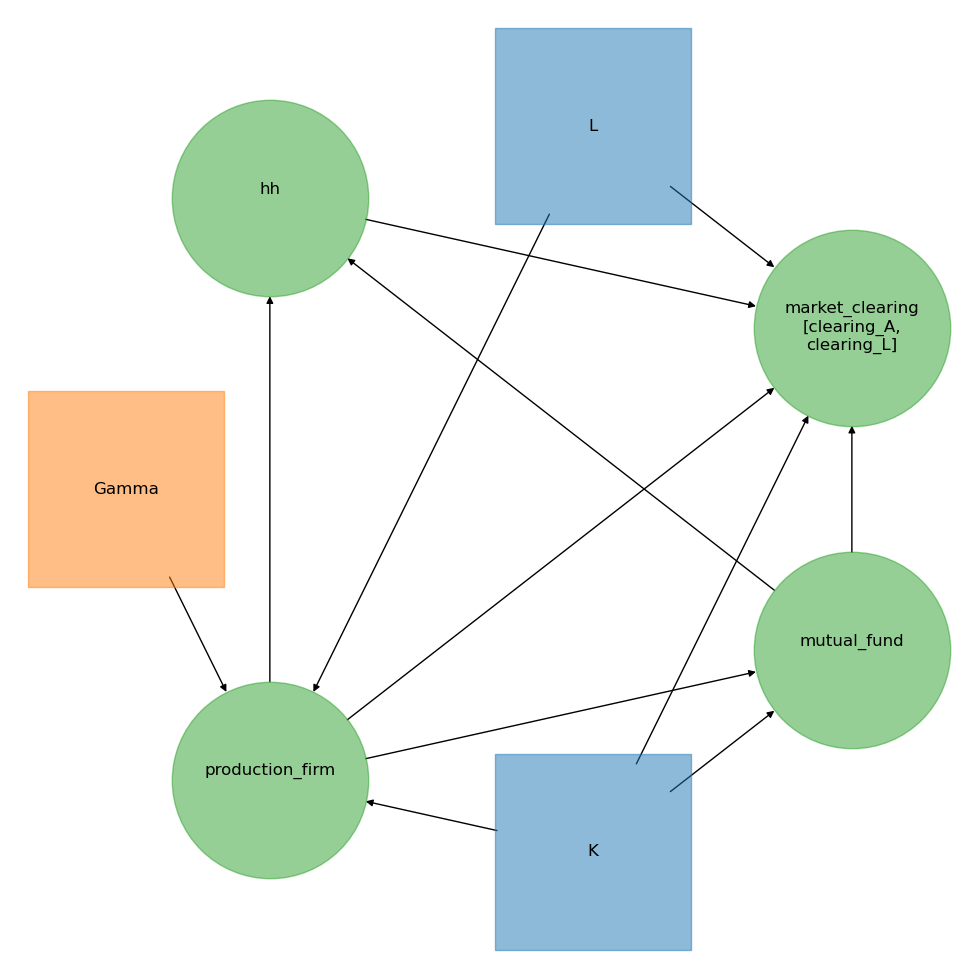

In [5]:
model.info(only_blocks=True)
model.draw_DAG(figsize=(10,10))

## 2. <a id='toc2_'></a>[Transition path](#toc0_)

### 2.1. <a id='toc2_1_'></a>[Step 1: steady state](#toc0_)

In [6]:
model.find_ss(method='direct',do_print=True)

### step 1: broad search ###

guess ss.K = 1.0000
implied ss.r = 0.1767
implied ss.w = 0.4200
error solving =  3.456079866737127e-11
solve_hh_ss(), too many iterations
clearing_A =          nan

guess ss.K = 2.0000
implied ss.r = 0.0990
implied ss.w = 0.5291
error solving =  2.7284841053187847e-12
solve_hh_ss(), too many iterations
clearing_A =          nan

guess ss.K = 3.0000
implied ss.r = 0.0676
implied ss.w = 0.6057
household problem in ss solved in 0.1 secs [627 iterations]
household problem in ss simulated in 0.8 secs [783 iterations]
implied ss.A_hh = 6142.6964
clearing_A = -6139.69636446

guess ss.K = 4.0000
implied ss.r = 0.0500
implied ss.w = 0.6667
household problem in ss solved in 0.1 secs [602 iterations]
household problem in ss simulated in 0.1 secs [2702 iterations]
implied ss.A_hh = 3.9991
clearing_A =   0.00085266

guess ss.K = 5.0000
implied ss.r = 0.0385
implied ss.w = 0.7181
household problem in ss solved in 0.1 secs [505 iterations]
household problem in ss simulat

Check if path is consistent with steady state 

In [7]:
model.test_path()

shocks: Gamma 
unknowns: K L 

look at max(abs(path.VARNAME[:]-ss.VARNAME)):

 blocks.production_firm
  rK               0.0e+00
  w                0.0e+00
  Y                0.0e+00
 blocks.mutual_fund
  A                0.0e+00
  r                0.0e+00
 hh
  A_hh             1.5e-08
  C_hh             8.6e-10
 blocks.market_clearing
  I                2.8e-17
  clearing_A       1.5e-08 [target]
  clearing_L       0.0e+00 [target]
  clearing_Y       8.6e-10


### 2.2. <a id='toc2_2_'></a>[Step 2: Jacobian](#toc0_)

We can compute the full jacobian (including HH jacobian) as follows:

In [8]:
model.compute_jacs(do_print=True, skip_shocks = True) # if skip_shocks = True the full Jacobians to shocks are  not computed

household Jacobians:
one step deviation from steady state calculated in 0.0 secs
curly_Y and curly_D calculated for r               in 0.1 secs
curly_Y and curly_D calculated for w               in 0.1 secs
curly_E calculated in 0.5 secs
builiding blocks combined in 0.1 secs
household Jacobian computed in 0.7 secs

full Jacobians:
full Jacobian to unknowns computed in 0.1 secs [in evaluate_blocks(): 0.1 secs]


In [9]:
print(f'Jacobian size : {model.H_U.shape}')
print(f'Should be: {par.T*len(model.unknowns), par.T*len(model.unknowns)}')

Jacobian size : (1000, 1000)
Should be: (1000, 1000)


In [10]:
model.H_U[:5,:5] # Jacobian

array([[1.01066215, 0.00989195, 0.00921299, 0.00859759, 0.00803529],
       [0.01387923, 1.02034175, 0.01894557, 0.01767995, 0.01652125],
       [0.01422888, 0.02336334, 1.02923796, 0.02728299, 0.02549288],
       [0.01451863, 0.02354302, 0.03210993, 1.03744784, 0.03498636],
       [0.01476861, 0.02368004, 0.03215108, 0.04019626, 1.04504308]])

We can also do this sequentially if we want 

In [11]:
model._compute_jac_hh(do_print=True)

one step deviation from steady state calculated in 0.0 secs
curly_Y and curly_D calculated for r               in 0.2 secs
curly_Y and curly_D calculated for w               in 0.1 secs
curly_E calculated in 0.0 secs
builiding blocks combined in 0.1 secs
household Jacobian computed in 0.4 secs


In [12]:
model.compute_jacs(do_print=True, skip_shocks=True, skip_hh=True)

full Jacobians:
full Jacobian to unknowns computed in 0.1 secs [in evaluate_blocks(): 0.1 secs]


In [13]:
model.H_U[:5,:5] # Jacobian

array([[1.01066215, 0.00989195, 0.00921299, 0.00859759, 0.00803529],
       [0.01387923, 1.02034175, 0.01894557, 0.01767995, 0.01652125],
       [0.01422888, 0.02336334, 1.02923796, 0.02728299, 0.02549288],
       [0.01451863, 0.02354302, 0.03210993, 1.03744784, 0.03498636],
       [0.01476861, 0.02368004, 0.03215108, 0.04019626, 1.04504308]])

### 2.3. <a id='toc2_3_'></a>[Step 3: Define shock](#toc0_)

Option 1: If we provide shocks as a list, GEModeltools uses preset information for model.par

In [14]:
shocks = ['Gamma']
# Shock is gonna be dGamma = par.jump_Gamma * rho_Gamma ** np.arange(par.T)

Option 2: Provide custom shock as dictionary 

In [15]:
#dGamma = np.zeros(par.T)
#dGamma[:4] = 0.01 
#shocks = {'dGamma' : dGamma}

### 2.4. <a id='toc2_4_'></a>[Step 4: Solve using Broyden's method](#toc0_)

In [16]:
model.find_transition_path(shocks, do_print=True)

finding the transition path:
 it =   0 -> max. abs. error = 2.49e-01
   2.49e-01 in clearing_A
   0.00e+00 in clearing_L
 it =   1 -> max. abs. error = 4.13e-03
   4.13e-03 in clearing_A
   0.00e+00 in clearing_L
 it =   2 -> max. abs. error = 3.95e-05
   3.95e-05 in clearing_A
   0.00e+00 in clearing_L
 it =   3 -> max. abs. error = 1.15e-07
   1.15e-07 in clearing_A
   0.00e+00 in clearing_L
 it =   4 -> max. abs. error = 1.03e-09
   1.03e-09 in clearing_A
   0.00e+00 in clearing_L
 it =   5 -> max. abs. error = 7.63e-12
   7.63e-12 in clearing_A
   0.00e+00 in clearing_L

transition path found in 1.5 secs


### shocks ###


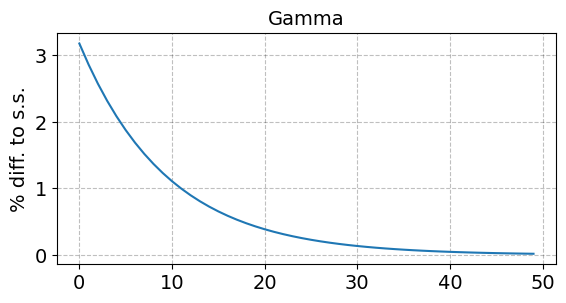


### varnames ###


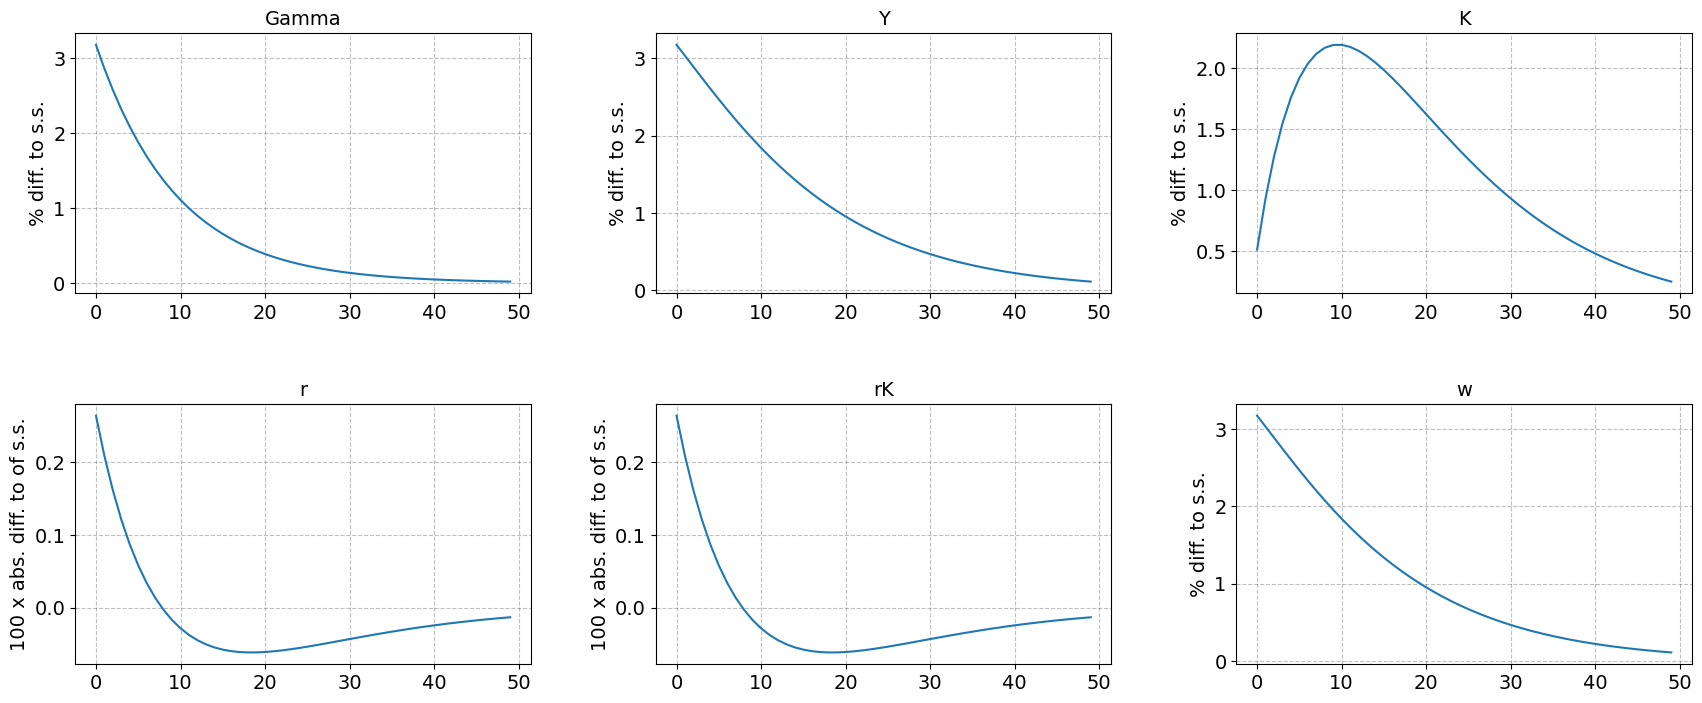


### targets ###


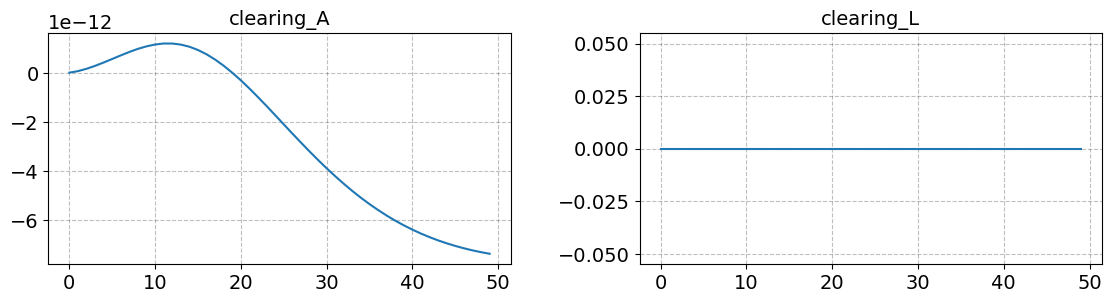

In [17]:
paths = ['Gamma','Y','K','r','rK','w']
abs_diff = ['r','rK']
facs = {'r':100,'rK':100}
model.show_IRFs(paths,abs_diff=abs_diff,facs=facs,ncols=3,T_max=50)

Non-linear path can be found in 

In [18]:
model.path.Y 

array([[1.03174503],
       [1.0303279 ],
       [1.02889846],
       [1.02747326],
       [1.02606525],
       [1.02468449],
       [1.02333872],
       [1.02203371],
       [1.02077373],
       [1.01956173],
       [1.01839966],
       [1.01728859],
       [1.01622895],
       [1.01522058],
       [1.01426292],
       [1.01335504],
       [1.01249576],
       [1.01168366],
       [1.0109172 ],
       [1.01019472],
       [1.00951446],
       [1.00887464],
       [1.00827346],
       [1.0077091 ],
       [1.00717975],
       [1.00668366],
       [1.00621908],
       [1.00578432],
       [1.00537774],
       [1.00499776],
       [1.00464285],
       [1.00431155],
       [1.00400245],
       [1.00371421],
       [1.00344557],
       [1.0031953 ],
       [1.00296226],
       [1.00274535],
       [1.00254354],
       [1.00235585],
       [1.00218135],
       [1.00201919],
       [1.00186854],
       [1.00172863],
       [1.00159874],
       [1.00147819],
       [1.00136633],
       [1.001

## 3. <a id='toc3_'></a>[HH jacobian + decomposition](#toc0_)

Look at HH Jacobian

In [19]:
model.jac_hh[('A_hh', 'w')].shape

(500, 500)

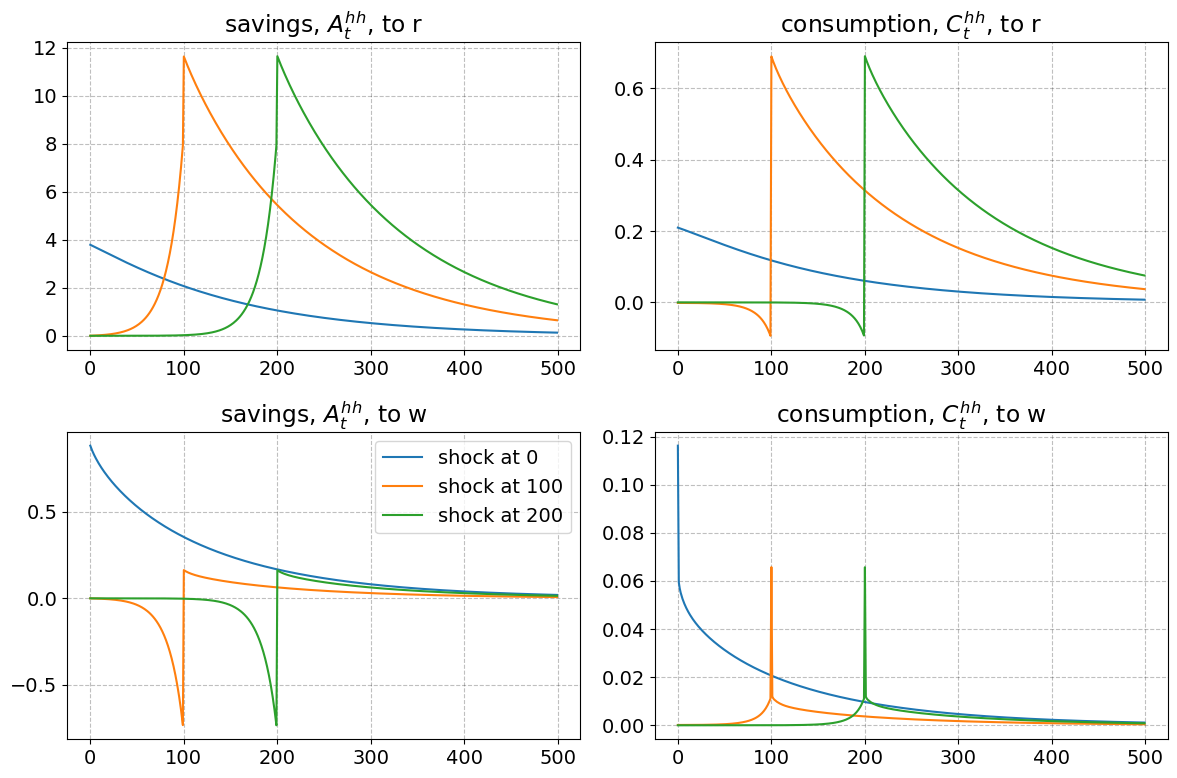

In [20]:
fig = plt.figure(figsize=(12,len(model.inputs_hh_all)*4),dpi=100)

i = 0
for varname in model.inputs_hh:
    
    # a. savings
    i += 1    
    ax = fig.add_subplot(len(model.inputs_hh_all),2,i)
    ax.set_title(r'savings, $A^{hh}_t$, to' + f' {varname}')
    for s in [0,100,200]:
        jac_hh_var = model.jac_hh[('A_hh',varname)]
        ax.plot(np.arange(par.T),jac_hh_var[:,s],label=f'shock at {s}')

    if i == 3: ax.legend(frameon=True)

    # b. consumption
    i += 1    
    ax = fig.add_subplot(len(model.inputs_hh_all),2,i)
    ax.set_title(r'consumption, $C^{hh}_t$, to' + f' {varname}')
    for s in [0,100,200]:
        jac_hh_var = model.jac_hh[('C_hh',varname)]
        ax.plot(np.arange(par.T),jac_hh_var[:,s],label=f'shock at {s}')

fig.tight_layout()

In [21]:
model.jac[('r','K')][:,0]

array([ 0.       , -0.0138888,  0.       ,  0.       ,  0.       ,
        0.       ,  0.       ,  0.       ,  0.       ,  0.       ,
        0.       ,  0.       ,  0.       ,  0.       ,  0.       ,
        0.       ,  0.       ,  0.       ,  0.       ,  0.       ,
        0.       ,  0.       ,  0.       ,  0.       ,  0.       ,
        0.       ,  0.       ,  0.       ,  0.       ,  0.       ,
        0.       ,  0.       ,  0.       ,  0.       ,  0.       ,
        0.       ,  0.       ,  0.       ,  0.       ,  0.       ,
        0.       ,  0.       ,  0.       ,  0.       ,  0.       ,
        0.       ,  0.       ,  0.       ,  0.       ,  0.       ,
        0.       ,  0.       ,  0.       ,  0.       ,  0.       ,
        0.       ,  0.       ,  0.       ,  0.       ,  0.       ,
        0.       ,  0.       ,  0.       ,  0.       ,  0.       ,
        0.       ,  0.       ,  0.       ,  0.       ,  0.       ,
        0.       ,  0.       ,  0.       ,  0.       ,  0.    

Find behavior when only some household inputs are active.

['r']
household problem solved along transition path in 0.1 secs
household problem simulated along transition in 0.0 secs

['w']
household problem solved along transition path in 0.1 secs
household problem simulated along transition in 0.0 secs

None
household problem solved along transition path in 0.1 secs
household problem simulated along transition in 0.0 secs

all
household problem solved along transition path in 0.1 secs
household problem simulated along transition in 0.0 secs



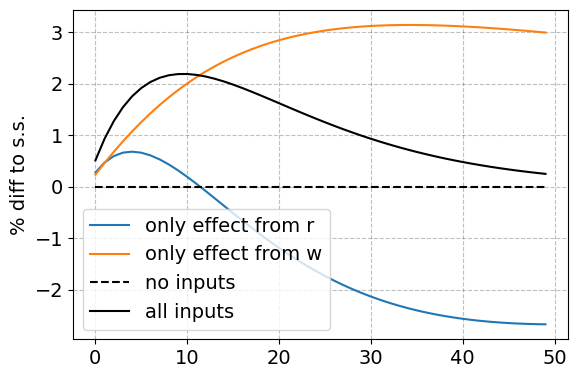

In [22]:
T_max = 50

fig = plt.figure(figsize=(6,4),dpi=100)
ax = fig.add_subplot(1,1,1)
    
i_color = 0
for use_inputs in [['r'],['w'],None,'all']:
    
    # a. compute
    print(use_inputs)
    path_alt = model.decompose_hh_path(do_print=True,use_inputs=use_inputs)
    print('')
    
    # b. plot
    if use_inputs is None:
        label = 'no inputs'
        ls = '--'
        color = 'black'
    elif use_inputs == 'all':
        label = 'all inputs'
        ls = '-'
        color = 'black'
    else:
        label = f'only effect from {use_inputs[0]}'
        ls = '-'
        color = colors[i_color]
        i_color += 1
        
    ax.plot((path_alt.A_hh[:50]/ss.A_hh-1)*100,ls=ls,color=color,label=label);

ax.set_ylabel('% diff to s.s.')
ax.legend(frameon=True)

fig.tight_layout()

## Permanent transition between two states

In [32]:
K_shock = -0.05

ini = {}
ini['Dbeg'] = np.zeros(ss.Dbeg.shape)
for i_a_lag in range(par.Na):
    
    # a. assets after shock
    a_lag = par.a_grid[i_a_lag]
    a_lag_after = a_lag*(1+K_shock)
    
    # b. new grid point
    for i in range(par.Na-1):
        if not par.a_grid[i+1] <= a_lag_after: break
    
    # c. distribute mass
    w = (par.a_grid[i+1]-a_lag_after)/(par.a_grid[i+1]-par.a_grid[i])
    
    for i_fix in range(par.Nfix):
        ini['Dbeg'][i_fix,:,i] += w*ss.Dbeg[i_fix,:,i_a_lag]
        ini['Dbeg'][i_fix,:,i+1] += (1-w)*ss.Dbeg[i_fix,:,i_a_lag]    

In [38]:
ini_K = ini['K'] = np.sum(par.a_grid*ini['Dbeg'])
print(f'{ss.K  = :.3f}')
print(f'{ini_K = :.3f}')

ss.K  = 4.000
ini_K = 3.800


In [ ]:
model.find_transition_path(do_print=True,ini=ini,shocks=[]) 

finding the transition path:
 it =   0 -> max. abs. error = 1.99e-01
   1.99e-01 in clearing_A
   0.00e+00 in clearing_L
 it =   1 -> max. abs. error = 1.31e-03
   1.31e-03 in clearing_A
   0.00e+00 in clearing_L
 it =   2 -> max. abs. error = 1.10e-05
   1.10e-05 in clearing_A
   0.00e+00 in clearing_L
 it =   3 -> max. abs. error = 9.74e-08
   9.74e-08 in clearing_A
   0.00e+00 in clearing_L
 it =   4 -> max. abs. error = 6.20e-10
   6.20e-10 in clearing_A
   0.00e+00 in clearing_L
 it =   5 -> max. abs. error = 1.99e-12
   1.99e-12 in clearing_A
   0.00e+00 in clearing_L

transition path found in 1.5 secs


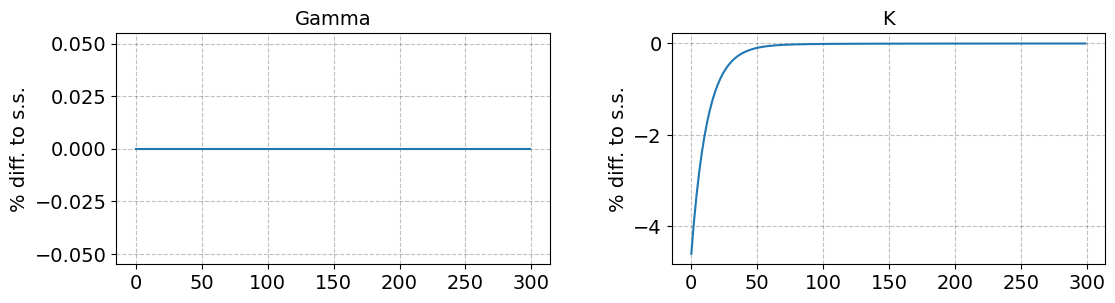

In [ ]:
model.show_IRFs(['Gamma','K'],T_max=300,do_shocks=False,do_targets=False,ncols=2)

# Transition between two steady states

In [47]:
ini = {}
ini['Dbeg'] = ss.Dbeg.copy()
ini['K'] = ss.K

model_term = model.copy()
model_term.par.Gamma_ss = model.par.Gamma_ss * 1.05
model_term.find_ss(method='direct',do_print=True) 

### step 1: broad search ###

guess ss.K = 1.0000
implied ss.r = 0.1872
implied ss.w = 0.4410
error solving =  1.77351466845721e-11
solve_hh_ss(), too many iterations
clearing_A =          nan

guess ss.K = 2.0000
implied ss.r = 0.1056
implied ss.w = 0.5556
error solving =  5.4569682106375694e-12
solve_hh_ss(), too many iterations
clearing_A =          nan

guess ss.K = 3.0000
implied ss.r = 0.0727
implied ss.w = 0.6360
error solving =  1.8189894035458565e-12
solve_hh_ss(), too many iterations
clearing_A =          nan

guess ss.K = 4.0000
implied ss.r = 0.0542
implied ss.w = 0.7000
household problem in ss solved in 0.1 secs [607 iterations]
household problem in ss simulated in 0.3 secs [9661 iterations]
implied ss.A_hh = 7009.3895
clearing_A = -7005.38953682

guess ss.K = 5.0000
implied ss.r = 0.0421
implied ss.w = 0.7541
household problem in ss solved in 0.1 secs [589 iterations]
household problem in ss simulated in 0.0 secs [498 iterations]
implied ss.A_hh = 0.4946
clearing_A =   4.

In [45]:
model_term.compute_jacs()
model_term.find_transition_path(do_print=True,ini=ini,shocks=[])

finding the transition path:
 it =   0 -> max. abs. error = 2.00e-01
   2.00e-01 in clearing_A
   0.00e+00 in clearing_L
 it =   1 -> max. abs. error = 1.17e-03
   1.17e-03 in clearing_A
   0.00e+00 in clearing_L
 it =   2 -> max. abs. error = 9.74e-06
   9.74e-06 in clearing_A
   0.00e+00 in clearing_L
 it =   3 -> max. abs. error = 7.41e-08
   7.41e-08 in clearing_A
   0.00e+00 in clearing_L
 it =   4 -> max. abs. error = 3.59e-10
   3.59e-10 in clearing_A
   0.00e+00 in clearing_L
 it =   5 -> max. abs. error = 1.71e-12
   1.71e-12 in clearing_A
   0.00e+00 in clearing_L

transition path found in 1.6 secs


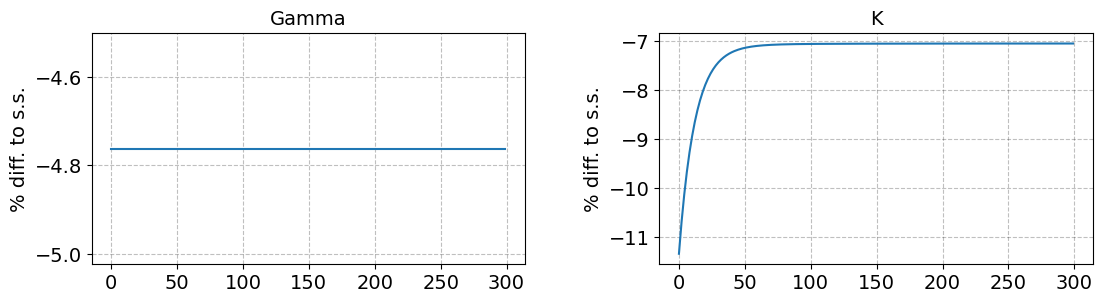

In [49]:
model_term.show_IRFs(['Gamma','K'],T_max=300,do_shocks=False,do_targets=False,ncols=2)

## Linear transitions

In [ ]:
model.compute_jacs()
model.find_transition_path(shocks=['Gamma'],do_print=False, do_end_check=False) 

In [24]:

model.find_IRFs(shocks=['Gamma'],do_print=True)

linear transition path found in 0.0 secs [finding solution matrix: 0.0 secs]


In [25]:
model.IRF['K']

array([ 2.05252330e-02,  3.73214306e-02,  5.08994713e-02,  6.17073593e-02,
        7.01374298e-02,  7.65336148e-02,  8.11967940e-02,  8.43896365e-02,
        8.63412623e-02,  8.72512039e-02,  8.72928170e-02,  8.66164353e-02,
        8.53521045e-02,  8.36120922e-02,  8.14930400e-02,  7.90778860e-02,
        7.64375703e-02,  7.36325428e-02,  7.07141135e-02,  6.77256156e-02,
        6.47034369e-02,  6.16779225e-02,  5.86741891e-02,  5.57128225e-02,
        5.28104936e-02,  4.99805063e-02,  4.72332735e-02,  4.45767340e-02,
        4.20167177e-02,  3.95572639e-02,  3.72008987e-02,  3.49488756e-02,
        3.28013862e-02,  3.07577424e-02,  2.88165337e-02,  2.69757640e-02,
        2.52329713e-02,  2.35853286e-02,  2.20297288e-02,  2.05628587e-02,
        1.91812607e-02,  1.78813866e-02,  1.66596412e-02,  1.55124197e-02,
        1.44361383e-02,  1.34272592e-02,  1.24823113e-02,  1.15979066e-02,
        1.07707530e-02,  9.99766427e-03,  9.27556786e-03,  8.60150978e-03,
        7.97265822e-03,  

linear transition path found in 0.0 secs [finding solution matrix: 0.0 secs]
### shocks ###


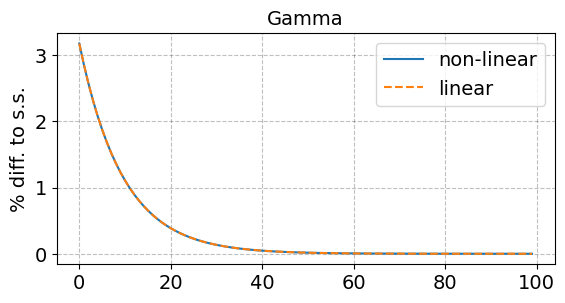


### varnames ###


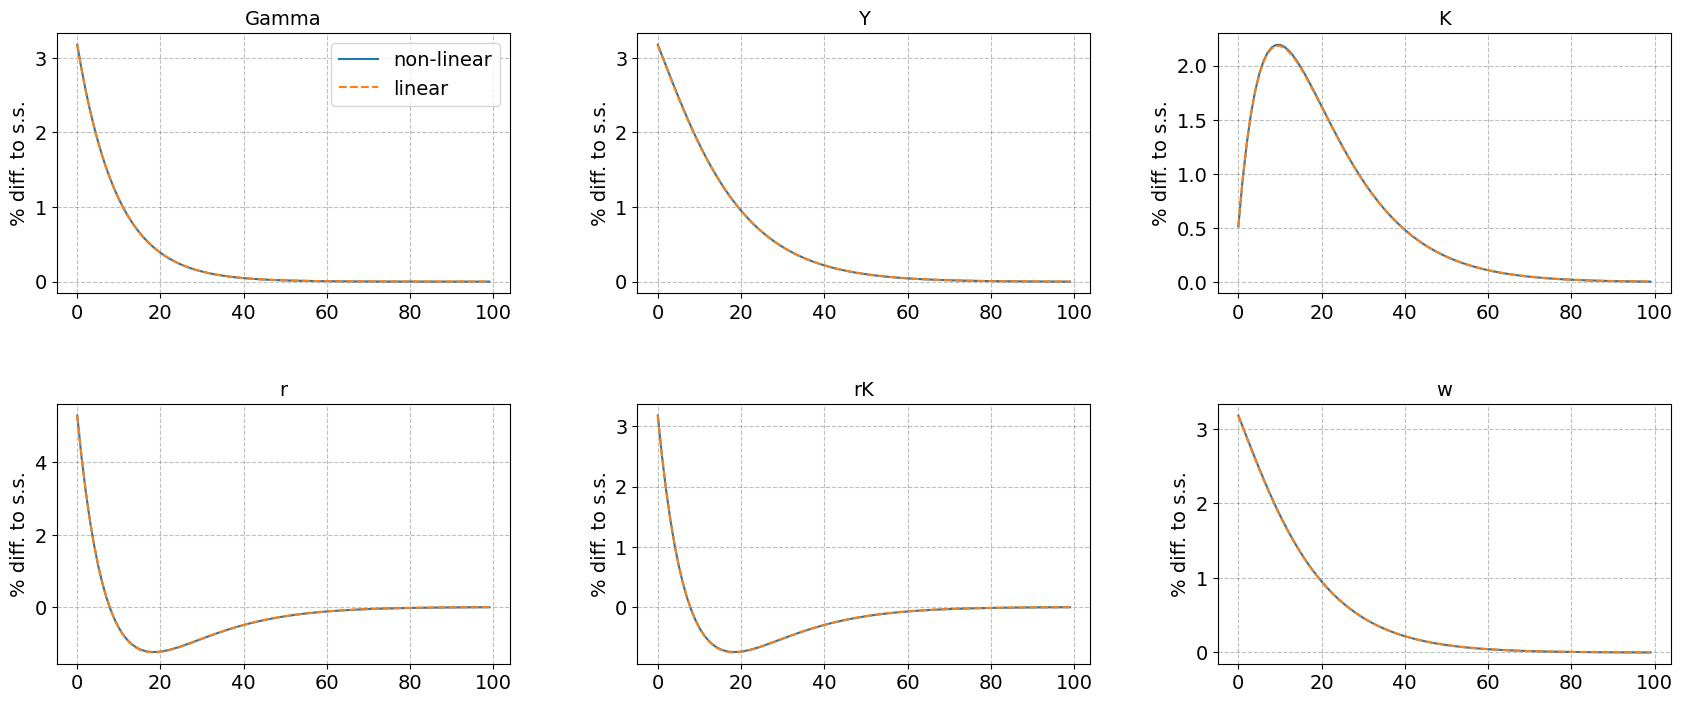


### targets ###


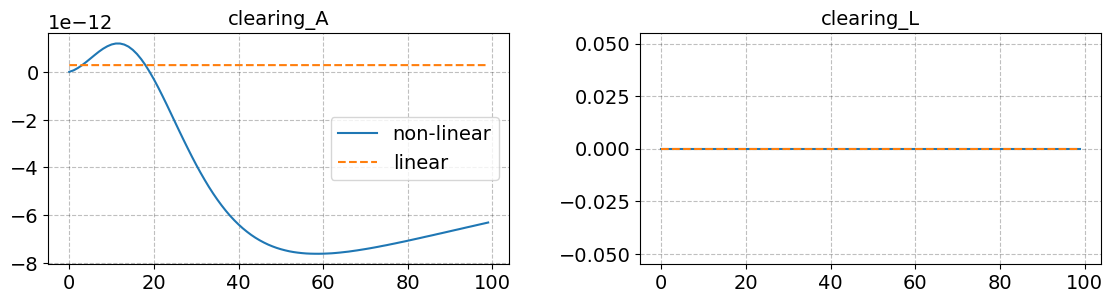

In [26]:

model.find_IRFs(shocks=['Gamma'],do_print=True)
model.show_IRFs(paths,ncols=3,T_max=100,do_linear=True)

linear transition path found in 0.0 secs [finding solution matrix: 0.0 secs]
### shocks ###


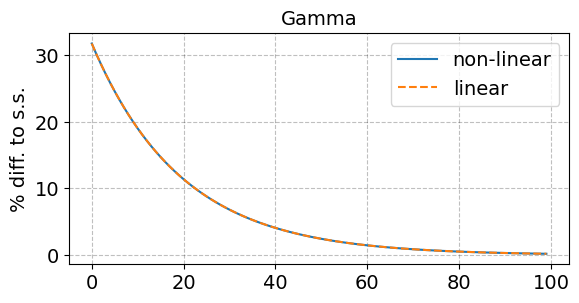


### varnames ###


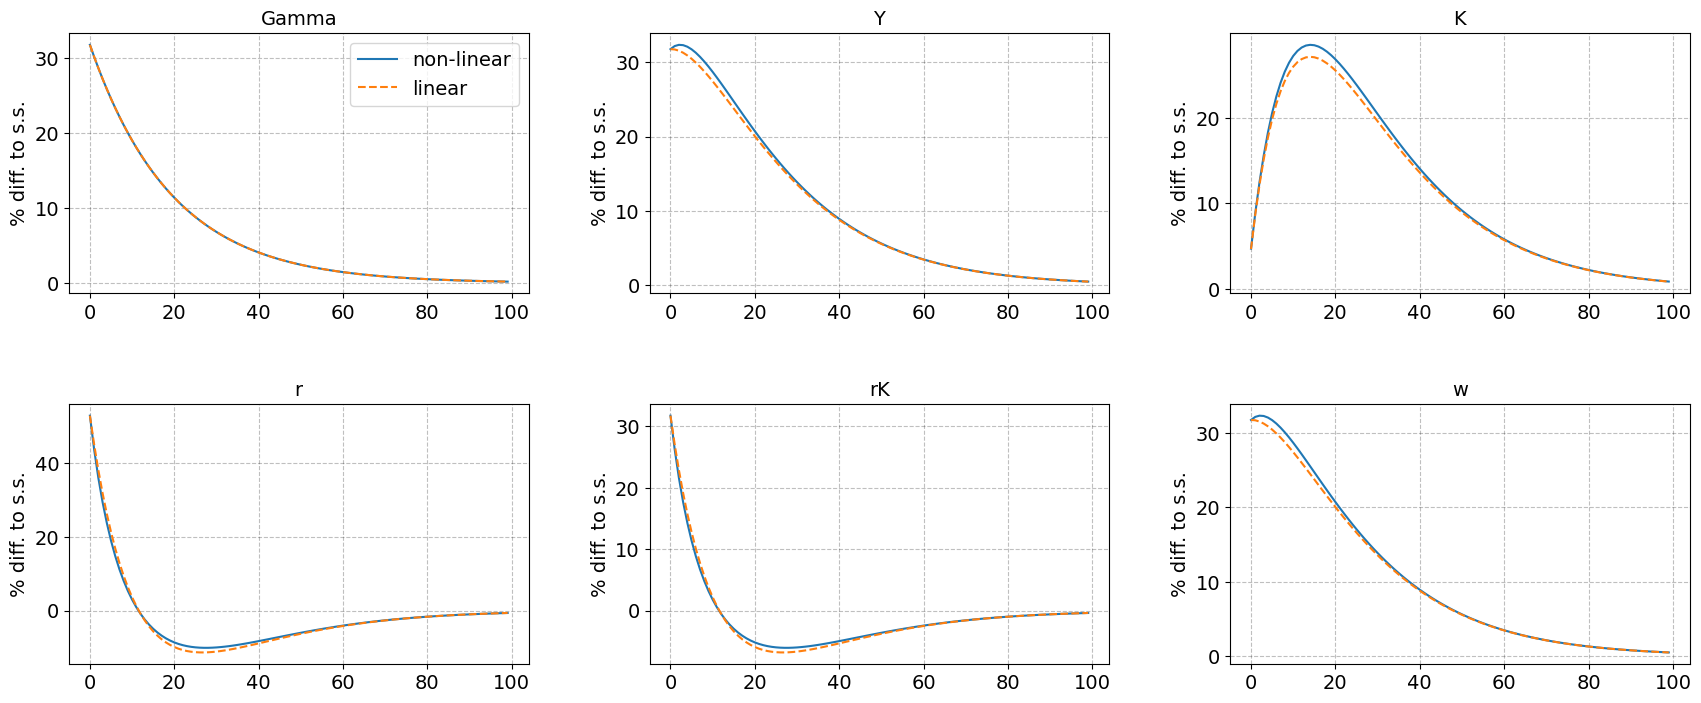


### targets ###


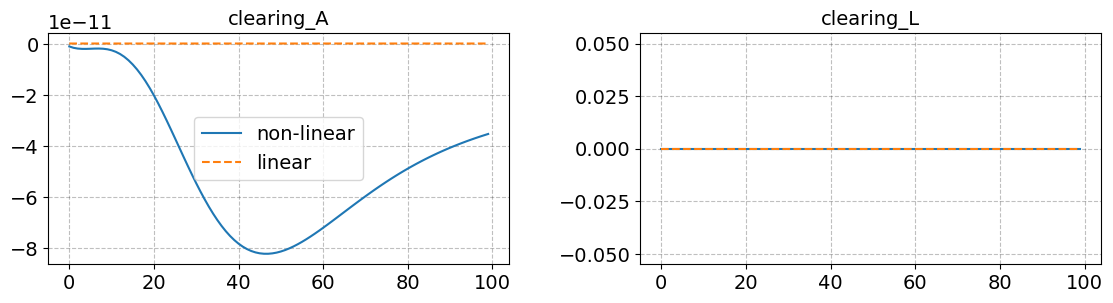

In [27]:
model.par.jump_Gamma = 0.2 # Huge shock!
model.par.rho_Gamma = 0.95
model.find_transition_path(shocks=['Gamma'],do_print=False, do_end_check=False)
model.find_IRFs(shocks=['Gamma'],do_print=True)

model.show_IRFs(paths,ncols=3,T_max=100,do_linear=True)

To plot things manually, use the following code

In [28]:
model.IRF['K']

array([ 1.85276985e-01,  3.46245563e-01,  4.85350566e-01,  6.04811676e-01,
        7.06642121e-01,  7.92672502e-01,  8.64564996e-01,  9.23826712e-01,
        9.71824503e-01,  1.00979732e+00,  1.03886671e+00,  1.06004745e+00,
        1.07425667e+00,  1.08232304e+00,  1.08499443e+00,  1.08294526e+00,
        1.07678308e+00,  1.06705469e+00,  1.05425182e+00,  1.03881611e+00,
        1.02114370e+00,  1.00158940e+00,  9.80470561e-01,  9.58070565e-01,
        9.34641948e-01,  9.10409353e-01,  8.85572171e-01,  8.60306943e-01,
        8.34769560e-01,  8.09097258e-01,  7.83410429e-01,  7.57814267e-01,
        7.32400273e-01,  7.07247626e-01,  6.82424417e-01,  6.57988787e-01,
        6.33989970e-01,  6.10469228e-01,  5.87460685e-01,  5.64992094e-01,
        5.43085532e-01,  5.21758031e-01,  5.01022145e-01,  4.80886468e-01,
        4.61356096e-01,  4.42433049e-01,  4.24116652e-01,  4.06403877e-01,
        3.89289650e-01,  3.72767133e-01,  3.56827973e-01,  3.41462529e-01,
        3.26660073e-01,  

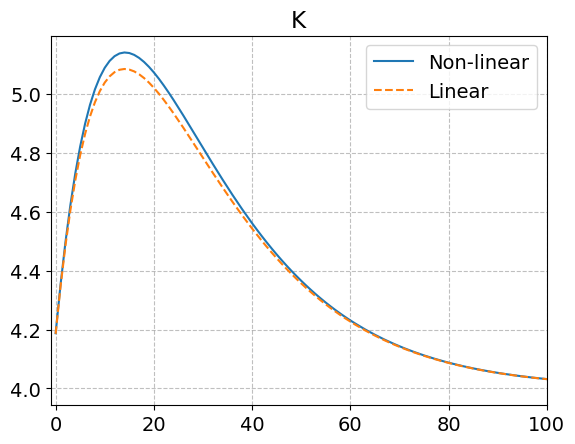

In [29]:
plt.plot(model.path.K, label='Non-linear')
plt.plot(model.ss.K + model.IRF['K'], label='Linear', linestyle = '--')
plt.legend()
plt.xlim(-1, 100)
plt.title('K')
plt.show()

## Simulations

- Draw a sequence of shocks using the specified parameters for $\Gamma$
- Simulate the economy using linear transitions

In [30]:
model.simulate(do_print=True)

simulation prepared in 1.2 secs [solution matrix: 0.0 secs, households: 1.2 secs]
aggregates simulated in 0.1 secs
household policies simulated in 3.1 secs
distribution simulated in 0.1 secs
aggregates calculated from distribution in 0.0 secs


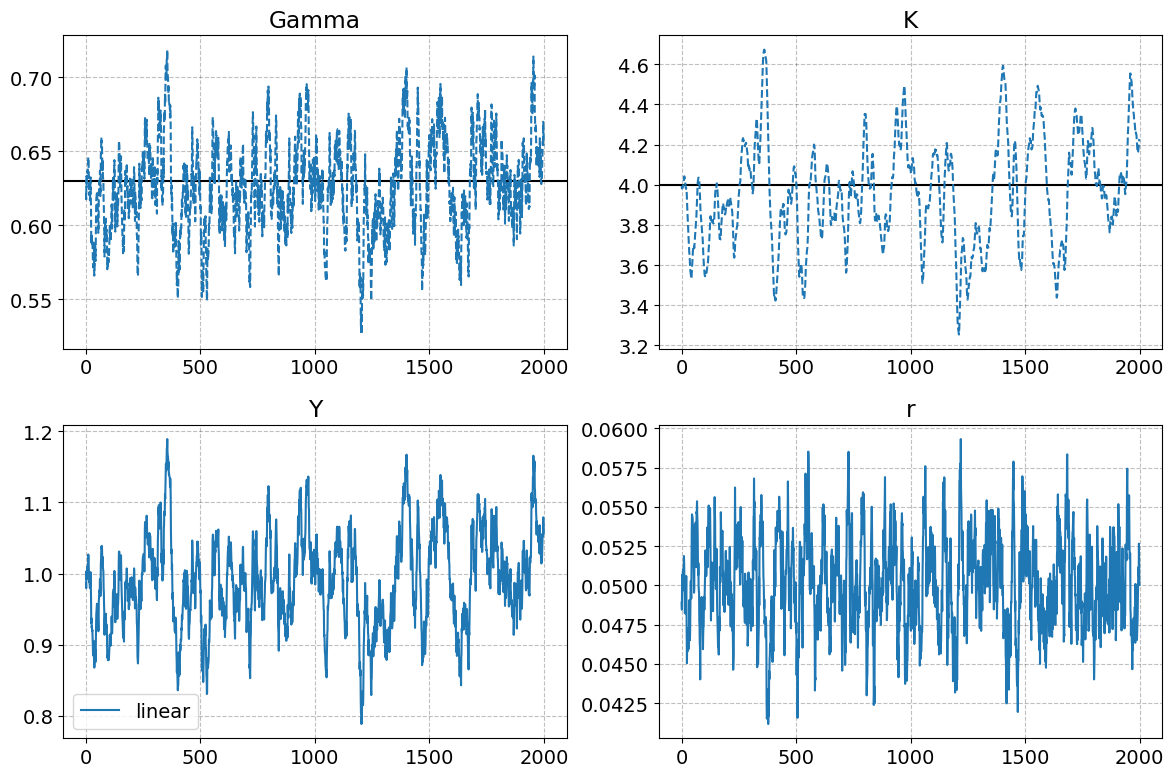

In [31]:


fig = plt.figure(figsize=(12,8),dpi=100)

ax = fig.add_subplot(2,2,1)
ax.set_title('Gamma')
ax.plot(ss.Gamma+sim.dGamma,ls='--')
ax.axhline(ss.Gamma,color='black',zorder=0)

ax = fig.add_subplot(2,2,2)
ax.set_title('K')
ax.plot(ss.K+sim.dK,ls='--',)
ax.axhline(ss.K,color='black',zorder=0)

ax = fig.add_subplot(2,2,3)
ax.set_title('Y')
ax.plot(ss.Y+sim.dY,ls='-',label='linear')
ax.legend(frameon=True)

ax = fig.add_subplot(2,2,4)
ax.set_title('r')
ax.plot(ss.r+sim.dr)

fig.tight_layout()